In [2]:
import torch
import torch.nn as nn
import torchvision
import numpy as np 
import matplotlib.pyplot as plt
from collections import OrderedDict

# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Reproducibility  
torch.manual_seed(0);

In [16]:
### Load Data ### 

#Use create a transform that uses bilinear interpolation to resize images to 64 square
im_size = 64
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(im_size),
    torchvision.transforms.ToTensor()
])

#load dataset and init dataloader (THIS WILL DOWNLOAD THE DATASET)
#dataloader will automatically batch and handle data
#The MNIST dataset is "premade," we will likely need to use TensorDataset to load our own datasets
mnist_dset_train = torchvision.datasets.MNIST(root = './data/', download=True, train = True, transform = transform)
batch_size = 128
mnist_DL = torch.utils.data.DataLoader(mnist_dset_train, shuffle=True, batch_size=batch_size) 

Image batch: torch.Size([128, 1, 64, 64])


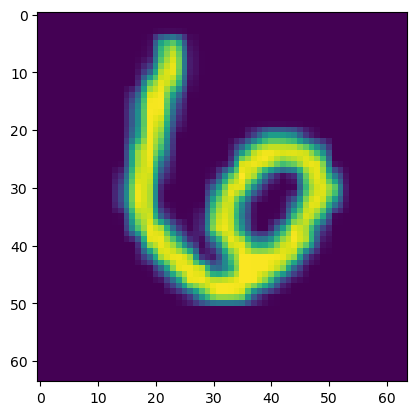

In [17]:
#show sample
sample = next(iter(mnist_DL))  #grab the next batch from the dataloader
print('Image batch:', sample[0].shape) #of shape batch_size x channels x W x H (channels = 1 for this grayscale dset)  
plt.imshow(sample[0][0,0])    #show the image
plt.show()

In [23]:
### Create Networks ###

#Autoencoder params
NN_width = 128 #size of hidden layers
n_hidden = 5  #number of hidden layers on either size of latent space
n_latent = 10 #size of latent space 

# Encoder as a fully connected network
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        #create input layer
        self.l1 = nn.Linear(im_size**2, NN_width)
        self.a1 = nn.LeakyReLU(0.2, inplace=True)

        #create hidden layers
        layers = []
        for i in range(n_hidden):
            layers.append(('hidden{}'.format(i+1),nn.Linear(NN_width, NN_width)))
            #layers.append(('batch norm{}'.format(i+1),nn.BatchNorm1d(NN_width)))
            layers.append(('ReLU{}'.format(i+1), nn.LeakyReLU(0.2, inplace=True)))
        self.hidden = nn.Sequential(OrderedDict(layers))

        #output layer
        self.out = nn.Linear(NN_width,n_latent)

    #forward pass
    def forward(self, x):
        x = x.view(x.size()[0],-1) #flatten the images into a vector
        x = self.l1(x)
        x = self.a1(x)
        x = self.hidden(x)
        return self.out(x)

# Decoder as a fully connected network
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        #create input layer
        self.l1 = nn.Linear(n_latent, NN_width)
        self.a1 = nn.LeakyReLU(0.2, inplace=True)

        #create hidden layers
        layers = []
        for i in range(n_hidden):
            layers.append(('hidden{}'.format(i+1),nn.Linear(NN_width, NN_width)))
            #layers.append(('batch norm{}'.format(i+1),nn.BatchNorm1d(NN_width)))
            layers.append(('ReLU{}'.format(i+1), nn.LeakyReLU(0.2, inplace=True)))
        self.hidden = nn.Sequential(OrderedDict(layers))

        #output layer
        self.out = nn.Linear(NN_width,im_size**2)

    #forward pass
    def forward(self, x):
        x = self.l1(x)
        x = self.a1(x)
        x = self.hidden(x)
        x = self.out(x)
        return x.view(x.size()[0],1,im_size,im_size) #reshape to image

In [30]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent = self.encoder(x)
        x = self.decoder(latent)
        return x, latent

In [32]:
#initialize and test networks 
#make sure to send everything to the correct device (important if you have GPU)
net = AutoEncoder().to(device)
reconst, latent = net(sample[0].to(device))
print('Reconstructed shape:', reconst.shape)
print('Latent shape:', latent.shape)

Reconstructed shape: torch.Size([128, 1, 64, 64])
Latent shape: torch.Size([128, 10])


In [25]:

# net_enc = Encoder().to(device)
# net_dec = Decoder().to(device)

# encoded = net_enc(sample[0].to(device))
# decoded = net_dec(encoded)

# print('Encoder Output Shape:', encoded.shape)
# print('Decoder Output Shape:', decoded.shape)
# print('Image batch shape:', sample[0].shape)

Encoder Output Shape: torch.Size([128, 10])
Decoder Output Shape: torch.Size([128, 1, 64, 64])
Image batch shape: torch.Size([128, 1, 64, 64])


In [28]:
#training parameters
epochs = 3          #one epoch is one iteration through the entire training cylce
iters_cycle = 100    #frequency of which to log results
error = torch.nn.MSELoss() 

In [33]:
### Train Autoencoder ###
LR = 0.001

#initialize error function and optimizer
opt = torch.optim.Adam(net.parameters(), betas=(0.5, 0.999), lr = LR)

#save losses
losses = []

#train
iters = 0

for epoch in range(epochs):
    #iterate through dataloader
    for batch in mnist_DL:
        #separate batch into labels and images
        images = batch[0].to(device)
        
        #make predictions
        reconst, latent = net(images)
        
        #calculate loss
        loss = error(reconst, images)
        
        #backpropagate gradients with Adam algorithm, this is the magic of pytorch and autograd
        loss.backward()
        opt.step()
        
        #reset gradients
        net.zero_grad()
        
        #save losses
        losses.append(loss.item())
        
        #log progress
        if iters%iters_cycle==0:    
            print('Epoch: {}/{}     Iter: {}     Loss: {}'.format(epoch, epochs, iters, loss.item()))
        iters +=1

Epoch: 0/3     Iter: 0     Loss: 0.10688576847314835
Epoch: 0/3     Iter: 100     Loss: 0.05132921412587166
Epoch: 0/3     Iter: 200     Loss: 0.05064859241247177
Epoch: 0/3     Iter: 300     Loss: 0.050327375531196594
Epoch: 0/3     Iter: 400     Loss: 0.04629340022802353
Epoch: 1/3     Iter: 500     Loss: 0.044453322887420654
Epoch: 1/3     Iter: 600     Loss: 0.039814673364162445
Epoch: 1/3     Iter: 700     Loss: 0.04165303707122803
Epoch: 1/3     Iter: 800     Loss: 0.036524418741464615
Epoch: 1/3     Iter: 900     Loss: 0.03633195906877518
Epoch: 2/3     Iter: 1000     Loss: 0.03200910985469818
Epoch: 2/3     Iter: 1100     Loss: 0.03087368980050087
Epoch: 2/3     Iter: 1200     Loss: 0.028693120926618576
Epoch: 2/3     Iter: 1300     Loss: 0.02791854366660118
Epoch: 2/3     Iter: 1400     Loss: 0.029075244441628456


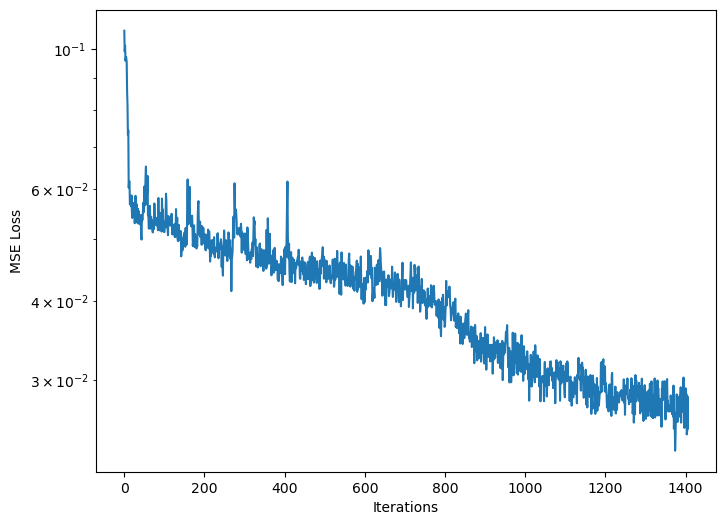

In [35]:
#plot loss curve 
plt.figure(figsize = (8,6))
plt.plot(losses)
plt.xlabel('Iterations')
plt.ylabel('MSE Loss')
plt.yscale('log')
plt.show()

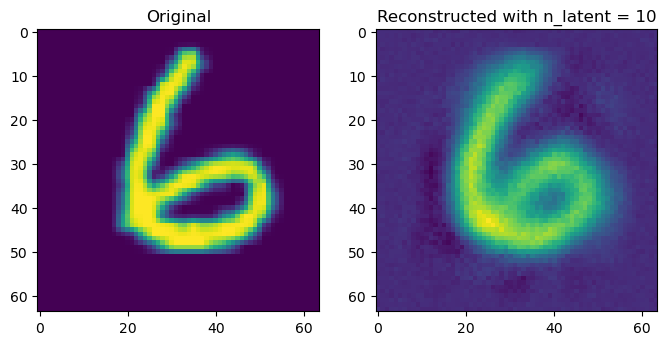

Reconstruction Error:  0.027021152898669243


In [39]:
#Create test dataset and load into dataloader
mnist_dset_test = torchvision.datasets.MNIST(root = './data/MNIST/', download=True, train = False, transform = transform)
num_samples = 500
mnist_DL_test = torch.utils.data.DataLoader(mnist_dset_test, shuffle=True, batch_size=num_samples)

#display sample with label and prediction
sample = next(iter(mnist_DL_test))
reconst, latent = net(sample[0].to(device))

# show image and reconstruction side by side 
fig, ax = plt.subplots(1,2, figsize = (8,4))
ax[0].imshow(sample[0][0,0])
ax[0].set_title('Original')
ax[1].imshow(reconst[0,0].detach().cpu())
ax[1].set_title('Reconstructed with n_latent = ' + str(n_latent))
plt.show()

print("Reconstruction Error: ", error(reconst, sample[0].to(device)).item())
